In [5]:
import pandas as pd
from pandas import DataFrame
#Load Data
def load_raw(path:str,debug:bool=False) -> DataFrame:
    df = pd.read_csv(path)
    #
    if debug:
        print(df.to_string())
    return df


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import spacy


def preprocess_data(df:DataFrame,save_to_file:bool=True,debug:bool=False):
    nlp = spacy.load("en_core_web_sm")
    # Function to lemmatize text using spaCy
    def lemmatize_text(text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc])
    data = df

    # Extract player names and remove from main data
    character_names = data.iloc[:, 0].tolist()
    main_data = data.iloc[:, 1:]

    # Identify numeric and text columns
    numeric_columns = main_data.select_dtypes(include=[np.number]).columns
    text_columns = main_data.select_dtypes(exclude=[np.number]).columns

    # Preprocess numeric columns
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    numeric_data = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(main_data[numeric_columns])), 
                                columns=numeric_columns)

    print(main_data[text_columns].shape)

    # Preprocess text columns using TfidfVectorizer and spaCy lemmatization
    #tfidf = TfidfVectorizer()  # You can adjust max_features as needed
    #text_data = main_data[text_columns].fillna('')
    #text_data_combined = text_data.apply(lambda x: ' '.join(x), axis=1)
    #lemmatized_text = text_data_combined.apply(lemmatize_text)
    #tfidf_matrix = tfidf.fit_transform(lemmatized_text)
    #tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # Combine processed data # tfidf_df
    processed_data = pd.concat([numeric_data], axis=1)
    processed_data.insert(loc = 0,
          column = "player",
          value = character_names)
    if save_to_file:
        processed_data.to_csv("processed_data.csv",index=False)
    return processed_data


In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def decompose_data(df: pd.DataFrame, method: str = "PCA", dimensions: int = 2, save_to_file: bool = True, debug: bool = False):
    """
    Function to apply dimensionality reduction using PCA or t-SNE and save correlations.

    Parameters:
    - df: Input DataFrame (includes the first column with names)
    - method: The dimensionality reduction method to use ("PCA" or "TSNE")
    - dimensions: Number of dimensions to reduce to (default is 3)
    - save_to_file: If True, saves the reduced DataFrame and correlation matrix to files
    - debug: If True, prints intermediate debugging information
    
    Returns:
    - Transformed DataFrame with reduced dimensions, preserving the first column with names
    """
    
    # Extract player names and remove from main data
    character_names = df.iloc[:, 0].tolist()
    main_data = df.iloc[:, 1:]
    
    # Perform dimensionality reduction based on the method
    if method.upper() == "PCA":
        pca = PCA(n_components=dimensions)
        reduced_data = pca.fit_transform(main_data)
        
        if debug:
            explained_variance = pca.explained_variance_ratio_
            print(f"Explained variance ratio by each principal component: {explained_variance}")
            print(f"Total explained variance: {explained_variance.sum()}")
    
    elif method.upper() == "TSNE":
        tsne = TSNE(n_components=dimensions, random_state=42)
        reduced_data = tsne.fit_transform(main_data)
        
        if debug:
            print(f"t-SNE with {dimensions} dimensions applied.")
    
    else:
        raise ValueError(f"Method '{method}' is not supported. Choose 'PCA' or 'TSNE'.")

    # Combine character names with the reduced data
    reduced_df = pd.DataFrame(reduced_data, columns=[f"Dimension_{i+1}" for i in range(dimensions)])
    reduced_df.insert(0, 'Name', character_names)

    # Calculate the correlations between the original features and the reduced dimensions
    correlations = pd.DataFrame(main_data).corrwith(pd.DataFrame(reduced_data), axis=0)
    correlation_df = pd.DataFrame(correlations, columns=["Correlation"]).T
    
    if save_to_file:
        reduced_df.to_csv("reduced_df.csv", index=False)
        correlation_df.to_csv("correlation_matrix.csv", index=False)

    if debug:
        print("Decomposition and correlation calculation completed.")
        print(f"Correlation matrix:\n{correlation_df}")
    
    return reduced_df, correlation_df


In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

def cluster_and_plot(df: pd.DataFrame, clusters: int = 3, dimensions: int = 2, debug: bool = False):
    """
    Function to perform clustering on the reduced data and plot the clusters.

    Parameters:
    - df: The input DataFrame (assumed to be the output from the decompose_data function).
    - clusters: Number of clusters for KMeans (default is 3).
    - dimensions: Number of dimensions for plotting (2 or 3).
    - debug: If True, prints additional information.
    
    Returns:
    - None, but plots the clustered data.
    """
    
    if dimensions not in [2, 3]:
        raise ValueError("Plotting only supports 2 or 3 dimensions.")
    
    # Extract player names and reduced data for clustering
    character_names = df['Name'].tolist()
    main_data = df.iloc[:, 1:].values  # Everything but the 'Name' column

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    df['Cluster'] = kmeans.fit_predict(main_data)
    
    if debug:
        print(f"Cluster centers: {kmeans.cluster_centers_}")
        print(f"Labels assigned to data points: {kmeans.labels_}")
    
    # 2D or 3D plot based on the 'dimensions' parameter
    if dimensions == 2:
        plt.figure(figsize=(10, 7),dpi=300)
        plt.scatter(df['Dimension_1'], df['Dimension_2'], c=df['Cluster'], cmap='viridis', s=50, alpha=0.7)
        
        # Annotate each point with its character name
        for i, name in enumerate(character_names):
            plt.text(df['Dimension_1'][i], df['Dimension_2'][i], name, fontsize=5, ha='right')

        plt.title(f'2D Clustering Plot with {clusters} Clusters')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        #plt.legend()
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 7),dpi=300)
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(df['Dimension_1'], df['Dimension_2'], df['Dimension_3'], c=df['Cluster'], cmap='viridis', s=50, alpha=0.7)
        
        # Annotate each point with its character name
        for i, name in enumerate(character_names):
            ax.text(df['Dimension_1'][i], df['Dimension_2'][i], df['Dimension_3'][i], name, fontsize=5)

        ax.set_title(f'3D Clustering Plot with {clusters} Clusters')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        #fig.legends(scatter, ax=ax, label='Cluster')
        plt.show()



(30, 0)


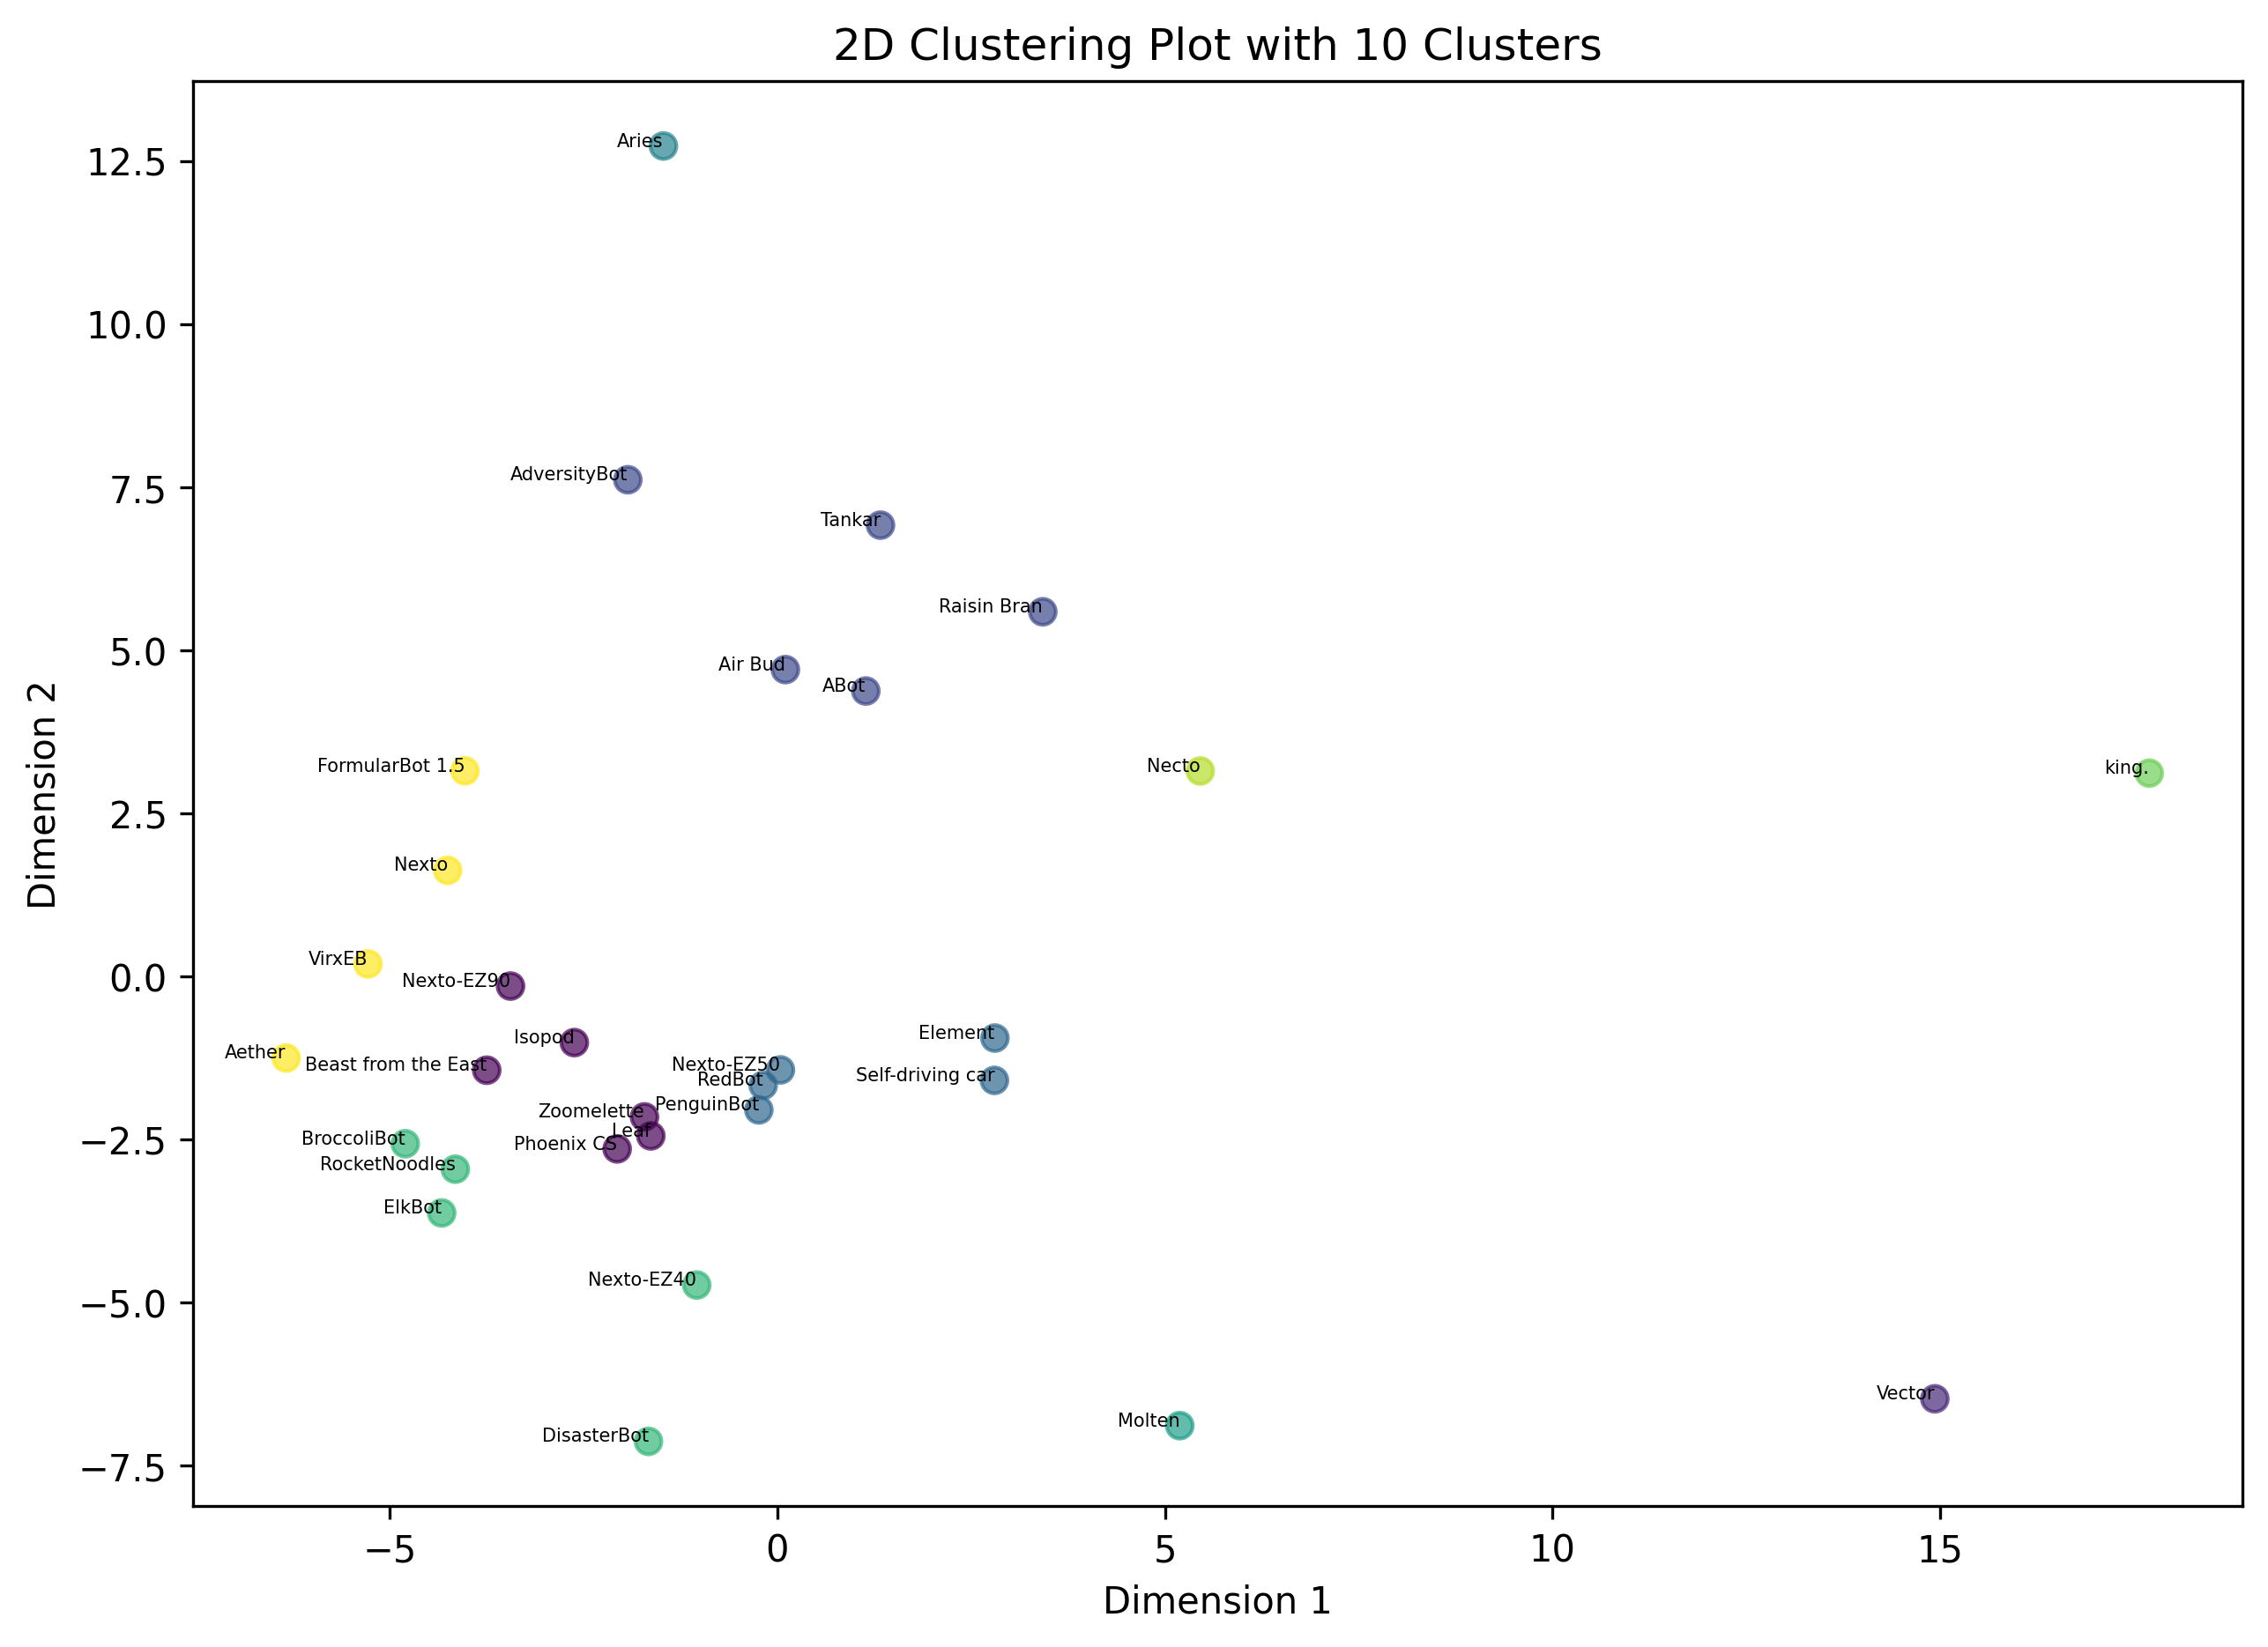

In [29]:
dims = 2
df = load_raw("raw_data.csv")
df = preprocess_data(df)
df = decompose_data(df,"PCA", dims)
df = cluster_and_plot(df,10,dims)